# Spooky Author Prediction 
(https://www.kaggle.com/c/spooky-author-identification/data) **to be removed...**

### 1. Data and Problem

- **Dataset description**:

The dataset contains text from works of fiction written by spooky authors of the public domain: `Edgar Allan Poe`, `HP Lovecraft` and `Mary Shelley`.

- **Problem statement**:

Given the training dataset, objective is to design a model that accurately predicts the author of the sentences in the test dataset.

In [71]:
# basic imports
import re
import string
import seaborn as sns
from scipy.sparse import coo_matrix

# nlp imports
import nltk
import pandas as pd

# basic classifiers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, linear_model, metrics, naive_bayes

# goodsie classifiers
import torch
import torch.nn as nn
from torch.autograd import Variable

### 2. Exploratory Data Analysis

**a) Load and check train data**

In [4]:
train_data = pd.read_csv("train.csv")
print(f'{train_data.shape} train data shape')
train_data.head(5)

(19579, 3) train data shape


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


**b) Count author frequencies in the dataset**

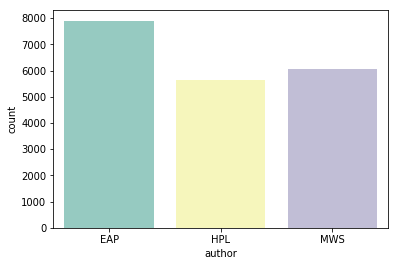

In [7]:
sns.countplot('author', data = train_data, palette="Set3")

As it does not make sense to do any further exploratory data analysis without pre-processing, we decided to move to `step-3` and revist `step-2` later.

### 3. Data Preprocessing

We have used the pre-processing techniques used throughout the course of the study group

- tokenize sentences
- remove stopwords
- remove numbers
- convert to lowercase
- lemmatizing (instead of `stemming`, as we had enough resources to cope with)

In [46]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
stopwords = nltk.corpus.stopwords.words('english')
train_features = []
train_labels = []

In [47]:
for sentence_index in range(train_data.shape[0]):
    sentence = train_data.text[sentence_index]
    author = train_data.author[sentence_index]
    
    # tokenize
    sentence_words = tokenizer.tokenize(sentence)
    
    # remove stopwords, covert to lowercase
    sentence_words = [word.lower() for word in sentence_words if word.lower() not in stopwords]
    
    # remove numbers
    words = [re.sub('[0-9]+', '', token) for token in sentence_words]
    
    # lemmatizing
    lemmatizer = WordNetLemmatizer()
    sentence_words = [lemmatizer.lemmatize(word) for word in sentence_words]
    
    train_features.append(' '.join(sentence_words))
    train_labels.append(author)
    
print(f'extracted {len(train_features)} training data features and labels')

extracted 19579 training data features and labels


**Vectorizing using tf-idf vectorizer**:

In [48]:
tfidf_vectorizer = TfidfVectorizer()
train_vectors = tfidf_vectorizer.fit_transform(train_features)

**Splitting the data into train and validation sets**:

In [50]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(train_vectors, train_labels, test_size=0.2, shuffle=True)
print(f'training dataset size: {X_train.shape}')
print(f'validation dataset size: {X_valid.shape}')

training dataset size: (15663, 22016)
validation dataset size: (3916, 22016)


### 4. Approaches

**a) Motivation**: Though our objective was essentially text classification, we discussed to experiment a bit with the representation/format of the dataset before trying out various classification methods

**b) Methods**:

- Logistic Regression (using tf-idf sentence vectors)

In [60]:
classifier = linear_model.LogisticRegression(C = 1.0)
classifier.fit(X_train, y_train)
predictions = classifier.predict_proba(X_valid)

print(f'logistic regression logloss: {metrics.log_loss(y_valid, predictions):0.4f}')

logistic regression logloss: 0.6298


- Naive Bayes (using tf-idf sentence vectors)

In [62]:
classifier = naive_bayes.MultinomialNB()
classifier.fit(X_train, y_train)
predictions = classifier.predict_proba(X_valid)

print(f'naive bayes logloss: {metrics.log_loss(y_valid, predictions):0.4f}')

naive bayes logloss: 0.6034


- Deep Neural Network (using tf-idf sentence vectors)

In [116]:
class DeepNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(DeepNN, self).__init__()
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, input):
        hidden = self.i2h(input)
        output = self.h2o(hidden)
        # softmax, because we are dealing with more than 2 spooky authors
        output = self.softmax(output)
        return output

In [90]:
def prepare_data():
    all_authors = list()
    all_words = list()
    
    def collect_unique():
        for index in range(len(train_features)):
            author = train_labels[index]
            sentence = train_features[index]
            if author not in all_authors:
                all_authors.append(author)
            
            for word in sentence.split(' '):
                if word not in all_words:
                    all_words.append(word)
        
    collect_unique()
    input_size = len(all_words)
    output_size = len(all_authors)
    return input_size, output_size, all_words, all_authors

In [108]:
def get_painful_tensors(author, sentence):
    def sentence_2_tensor(sentence):
        tensor = torch.zeros(1, input_size)
        for word in sentence.split(' '):
            if word not in all_words:
                continue
            tensor[0][all_words.index(word)] = 1
        
        return tensor
    
    author_tensor = Variable(torch.LongTensor([all_authors.index(author)]))
    return author_tensor, Variable(sentence_2_tensor(sentence))

In [101]:
def black_hole(output, input, deep_nn):
    deep_nn.zero_grad()
    
    output_p = deep_nn(input)
    loss = criterion(output_p, output)
    loss.backward()

    for param in deep_nn.parameters():
        param.data.add_(-learning_rate, param.grad.data)

    return output, loss.data[0]

In [125]:
def train(deep_nn, n_iters = 1):
    current_loss = 0
    for iter in range(1, n_iters + 1):
        for index in range(len(train_features)):
            author = train_labels[index]
            sentence = train_features[index]
            author_tensor, sentence_tensor = get_painful_tensors(author, sentence)
            output, loss = black_hole(author_tensor, sentence_tensor, deep_nn)
            current_loss += loss
    
    print(f'loss = {round(current_loss)}:0.3f')

In [122]:
# finally! start the computational graph
input_size, output_size, all_words, all_authors = prepare_data()
learning_rate = 0.005
hidden_size = input_size
deep_nn = DeepNN(input_size, hidden_size, output_size)
criterion = nn.NLLLoss()

In [ ]:
# needs to be run on Triton / GPU machines
train(deep_nn)

- Logistic regression (using doc2vec)

### 5. Experimental Results

|                      | logistic regression | naive bayes (multinomial) | deep neural network |
| :------------------: | :-----------------: | :-----------------------: | :-----------------: |
|       doc2vec        |                     |                           |                     |
|        tf-idf        |                     |                           |                     |

### 6. Conclusions